# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Autoencode](#classifier)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

### Pathways <a name="1pathways"></a>

In [3]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [ ]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [44]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (143234, 110)
Printing a row of Ux: 
 [0.07843621 0.31118352 0.68245424 1.15863002 1.69435217 2.2377946
 2.73607737 3.14059293 3.41183529 3.52330289 3.63726074 3.7439734
 3.84549407 3.94281205 4.03640323 4.12650964 4.2132592  4.29672103
 4.37693287 4.45391539 4.52767992 4.59823263 4.6655769  4.72971455
 4.79064658 4.84837353 4.90289569 4.95421322 5.00232621 5.04723472
 5.08893877 5.12743839 5.16273359 5.19482437 5.22371075 5.24939272
 5.2718703  5.29114348 5.30721227 5.32007667 5.32973668 5.33619229
 5.33944353 5.33997115 5.33936904 5.33787084 5.33552701 5.33235975
 5.32837974 5.3235924  5.31800058 5.31160582 5.30440894 5.29641041
 5.28761047 5.27800926 5.26760686 5.25640331 5.24439864 5.23159284
 5.21798594 5.20357794 5.18836883 5.17235862 5.15554731 5.13793491
 5.1195214  5.1003068  5.0802911  5.05947431 5.03785642 5.01543743
 4.99221734 4.96819616 4.94337388 4.9177505  4.89132603 4.86410046
 4.8360738  4.8

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [45]:
size = Ux.shape[0]/25
print("We have run", Ux.shape[0],"simulations with a step of",size)

We have run 137725 simulations with a step of 5509.0


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [46]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [78]:
ratio_pts = 0.1
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(13750, 110) (13750, 110)


In [79]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

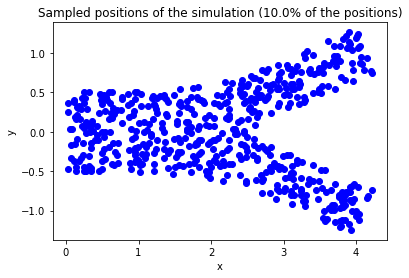

In [80]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a single matrix with dimensions $((2 N_u N_t), N_s)$

In [49]:
print(new_Ux)

[[0.06598187 0.25670229 0.55084151 ... 2.51511171 2.47896831 2.44227292]
 [0.01822349 0.06614118 0.13306091 ... 0.49577011 0.48856679 0.48125408]
 [0.06441595 0.25109322 0.5398679  ... 2.481933   2.44626963 2.41006156]
 ...
 [0.06643176 0.26403555 0.57958814 ... 3.08212344 3.0383942  2.99399259]
 [0.02092091 0.07525409 0.1493795  ... 0.45401539 0.44725713 0.44039752]
 [0.02068076 0.07446069 0.14793325 ... 0.45138163 0.44466495 0.43784753]]


In [50]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 121000)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u})}$

In [12]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

121000


## 3. Auto-encoder  <a name="autoencoder"></a>

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [13]:
# Set seed 
seed = 123
flattened_array_train, flattened_array_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = flattened_array_train, flattened_array_test

print(flattened_array_train.shape)
print(flattened_array_test.shape)

(495, 121000)
(55, 121000)


In [25]:
from autoencoder import *
train(flattened_array_train)

epoch : 1/100, loss = 10.052877
epoch : 2/100, loss = 9.828532
epoch : 3/100, loss = 9.584318
epoch : 4/100, loss = 9.310137
epoch : 5/100, loss = 9.010415
epoch : 6/100, loss = 8.696991
epoch : 7/100, loss = 8.373413
epoch : 8/100, loss = 8.052685
epoch : 9/100, loss = 7.776497
epoch : 10/100, loss = 7.544547
epoch : 11/100, loss = 7.311075
epoch : 12/100, loss = 7.057894
epoch : 13/100, loss = 6.775781
epoch : 14/100, loss = 6.502980
epoch : 15/100, loss = 6.245518
epoch : 16/100, loss = 6.058895
epoch : 17/100, loss = 5.908620
epoch : 18/100, loss = 5.778327
epoch : 19/100, loss = 5.649867
epoch : 20/100, loss = 5.510818
epoch : 21/100, loss = 5.285861
epoch : 22/100, loss = 4.826629
epoch : 23/100, loss = 3.983457
epoch : 24/100, loss = 2.769870
epoch : 25/100, loss = 1.615822
epoch : 26/100, loss = 0.999115
epoch : 27/100, loss = 0.902560
epoch : 28/100, loss = 0.901818
epoch : 29/100, loss = 0.901195
epoch : 30/100, loss = 0.900783
epoch : 31/100, loss = 0.900526
epoch : 32/100, 

## 4. Passer en 2D 

## 5. Hyper-parameters and physics parameters relationship

## 6. Discussion & conclusion